### Álvaro Plata, Brenda Barahona, Sofía Álvarez (201729031)

In [138]:
# ESAI
# Importamos todas las librerias necesarias para el laboratorio.
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from joblib import dump, load
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from pandas_profiling import ProfileReport
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

<h1 align='center'>Laboratorio 1: Inteligencia de Negocios</h1>

SaludAlpes es una entidad de salud colombiana que se especializa en atender pacientes diagnosticados con diabetes.
Entre las actividades principales de SaludAlpes se destaca el análisis de resultados de laboratorio para la detección de diabetes.
Este servicio de diagnóstico implica el análisis manual por parte de médicos especialistas, a partir de los resultados de exámenes de laboratorio, lo cual ha generado en los últimos años, una serie de problemas asociados con los tiempos de atención a estos pacientes, causada por demoras en la confirmación del diagnóstico.
SaludAlpes los ha contratado para agilizar y mejorar el proceso de análisis de resultados clínicos de tal manera que se reduzcan los tiempos de confirmación de diagnóstico y se agilice el inicio del tratamiento a paciente con diabetes confirmada.
Su labor como consultor de BI es agilizar el proceso de confirmación de diagnóstico de diabetes en un paciente, utilizando datos históricos y realizando sobre ellos procesos de análisis y procesamiento, al igual que comunicando los resultados a la entidad para afianzar sus conocimientos en áreas de aprendizaje automático y al mismo tiempo generar una ventaja competitiva.
Con el fin de lograr el objetivo para el cual fue contratado, SaludAlpes espera tener tres modelos distintos de clasificación, construidos con 3 técnicas diferentes, entre las cuales deben estar árboles de decisión y KNN (k-nearest-neighbours). 

### 1. Análisis exploratorio y perfilamiento de los datos.

Para poder realizar un buen algoritmo de Machine Learning, lo primero que debemos hacer es analizar y perfilar los datos, con el fin de prepararlos para los algoritmos que utilizaremos.

Lo primero que hacemos es leer los datos:

In [2]:
datos = pd.read_csv('202210_Laboratorio1_data_Datos_Clasificacion_2022.csv', delimiter=';', low_memory=False)

Cabe anotar que en este caso, debemos poner el atributo de baja memoria en False. Un warning decía que hay tipos de datos mixtos y, para evitarlo, debíamos hacer eso con el parámetro de la función <code>pd.read_csv()</code>.

Una vez leídos los datos, podemos ver la cantidad de columnas (features) y datos (filas) que tiene nuestro conjunto de datos:

In [3]:
datos.shape

(100000, 27)

En principio, nuestro conjunto de datos cuenta con 100.000 registros y 27 columnas. Veamos una muestra aleatoria de 5 datos del dataset:

In [4]:
display(datos.sample(5))

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,DiffWalk,Sex,Age,Education,Income,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
17697,0,0,0,1,25,1,0,0,1,0,...,0,0,6,6,8,NaN,NaN,NaN,NaN,NaN
48291,0,1,1,1,31,0,0,0,0,0,...,0,0,6,4,2,NaN,NaN,NaN,NaN,NaN
3845,0,0,0,1,23,0,0,0,1,1,...,0,0,3,5,4,NaN,NaN,NaN,NaN,NaN
89815,0,0,1,1,27,1,0,0,1,0,...,0,1,10,5,6,NaN,NaN,NaN,NaN,NaN
46944,1,1,1,1,24,1,0,0,1,0,...,0,0,9,3,1,NaN,NaN,NaN,NaN,NaN


Después de haber leído los datos, procedemos a hacer el reporte del <code>pandas_profiling:</code>

In [5]:
profiling = ProfileReport(datos)
profiling.to_file(output_file="pandas_profiling.html")
profiling

Summarize dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

En la tabla de DataSet Statistics, podemos ver que hay 22 variables categóricas y hubo problema cargando 5 de ellas. Adicional a esto, podemos evidenciar el porcentaje de filas duplicadas y de celdas que no tienen valores (o NaN), estos porcentajes son 5.8% y 18.5% respectivamente. Es importante notar que puede haber varias filas con celdas en NaN, para ello, se hace una exploración más exhaustiva más adelante. Las decisiones sobre eliminarlos o no se justifican en la sección de preprocesamiento y procesamiento.

Si quiere una descripción exhaustiva de cada una de las variables aquí descritas, remítase al informe anexo a este cuaderno. En este punto, mencionaremos algunos aspectos relevantes sobre el conjunto de datos. De lo que se puede ver en el pandas profiling, hay tres datos que presentan inconsistencias con respecto al diccionario. Estos son: -, Xx, ?. Podríamos pensar en eliminarlos, que fue lo que hicimos, como se explicará posteriormente.

Asimismo, es posible notar que hay unas columnas "Unnamed" que el pandas profiling no puede entender. Estas hacen que no se pueda observar la matriz de correlación (esta la hacemos al finalizar el preprocesamiento).

En principio, podemos intuir que la variable objetivo será <code>Diabetes_012</code>, porque de acuerdo con el diccionario del negocio, es la que nos permitirá saber si un paciente tiene diabetes, o ninguna condición, como es del interés de SaludAlpes. Es posible ver, a priori, que hay un claro desbalanceo en esta variable. Por tanto, debemos tener esto en cuenta en el procesamiento de los datos.

Antes de seguir con el preprocesamiento, hacemos la partición train_test, con train=80% de los datos y test=20%.

 No tomamos conjunto de validación pues haremos validación cruzada usando GridSearch para todos los modelos. Eliminamos la variable <code>Diabetes_012</code> de X_test y X_train y las convertimos en Y_test y Y_train, respectivamente.

In [184]:
Y = datos['Diabetes_012']
X = datos.drop(['Diabetes_012'], axis=1)

X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2, random_state=28)

Como análisis preliminar, podemos ver que la variable objetivo está desbalanceada, como vemos a continuación. Asimismo, vemos que hay mucha basura: -, ?, Xx. Esto lo trataremos más adelante.

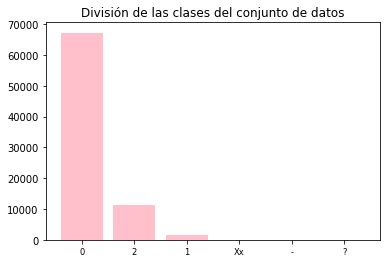

Veamos la cantidad de datos en cada clase: 


,Diabetes_012
0,67248
2,11190
1,1520
Xx,15
-,10
?,4


In [7]:
val_counts_y = Y_train.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='pink')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()
print('Veamos la cantidad de datos en cada clase: ')
Y_train.value_counts().to_frame()

Notamos entonces que, en efecto, las clases están desbalanceadas. Más aún, vemos que hay mucha basura, con caracteres que no están en el diccionario y que no tienen sentido con los datos. Estos debemos eliminarlos, como se hará más adelante.

Note que tenemos 67248 datos de la clase 0 (Normal), 1520 de la clase 1 (Prediabetes) y 11190 de la clase 2 (Diabetes).

### 2. Preprocesamiento

Volvemos a juntar las X, Y de entrenamiento para poder eliminar más adelante los registros completos de algunos datos, dadas ciertas condiciones, como se verá más adelante. Con ello, procedemos al preprocesamiento de los datos: eliminación e imputación de datos fuera de rango, inconsistentes, duplicados o nulos, según los criterios definidos por el negocio.

In [150]:
datos_train = X_train.assign(Diabetes_012 = Y_train)

Podemos ver el tamaño de nuestro nuevo conjunto de entrenamiento:

In [9]:
print('El tamaño del conjunto de entrenamiento es: {}'.format(len(datos_train)))

El tamaño del conjunto de entrenamiento es: 80000


Podemos ver que al final de esta muestra hay 5 columnas que aparecen sin nombre: Unnamed:22 hasta Unnamed:26, cuyos valores están todos en NaN. Por ello, decidimos revisar las otras columnas del dataframe y compararlas con el diccionario de datos dado para este laboratorio.

In [10]:
print(list(datos_train.columns))

['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Diabetes_012']


Contrastando los nombres de las columnas con el diccionario, vemos que las columnas 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25' y 'Unnamed: 26' no están caracterizadas por el negocio y, por tanto, no nos dan información relevante para el modelo. Más aún, podemos ver los valores únicos de cada una de estas columnas.

In [11]:
# Iteramos de 22 a 26 para conocer los valores únicos de cada una de las columnas Unnamed.
for i in range(22,27):
    print(datos_train['Unnamed: {num}'.format(num=i)].unique(), end=' ')

[nan] [nan] [nan] [nan] [nan] 

Vemos entonces que estas columnas están llenas de <code>NaN</code>; i.e. Not a Number. Por tanto, no aportan nada y procedemos a eliminarlas de nuestro conjunto de datos. Para ello, hacemos todo en funciones, con el fin de poder aplicar este pre-procesamiento al test también.

In [12]:
def eliminar_columnas_unnamed(df, col_inicial=22, col_final=26):
    # Eliminamos las últimas columnas
    return df.drop(['Unnamed: {num}'.format(num=i) for i in range(col_inicial, col_final+1)], axis=1)

In [13]:
datos_train = eliminar_columnas_unnamed(datos_train, 22, 26)

Revisamos que las columnas hayan sido correctamente eliminadas:

In [14]:
print(list(datos_train.columns))

['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Diabetes_012']


Ahora, ya tenemos todas las columnas que se encuentran en el diccionario. Lo siguiente que queremos ver es explorar los datos que hay en nuestro dataset. Nos preguntamos: ¿Por qué, al comienzo, tuvimos un _warning_ con los tipos de datos? ¿Qué datos están almacenados en el conjunto?

Revisando el diccionario de datos, nos dimos cuenta de que todos los atributos debían ser numéricos (así fueran categorías numéricas - como es el caso de columnas como GenHlth, Age y Education, entre otras - o binarias). Se nos ocurrió, entonces, revisar si las columnas estaban presentando otro tipo de datos no numéricos. Para ello, primero buscamos en el conjunto de datos todos los valores distintos que hay en nuestro dataframe y los convertimos en una lista. Luego, iteramos sobre ellos e intentamos convertirlos (hacer el cast) a números flotantes, usando un bloque try-except. Si se lanza una excepción, significa que el dato no es numérico y lo agregamos a la lista, para saber qué otro tipo de datos tiene nuestro dataframe.

In [15]:
# Vemos todos los valores distintos (únicos) que tiene el dataframe.
valores_distintos = list(datos_train.apply(pd.value_counts).index)
valores_no_numericos = []
# Interamos sobre los valores distintos
for val in valores_distintos:
    try:
        # Intentamos hacer el cast a float
        numero = float(val)
    except:
        # Si hay datos no numericos, los agregamos a la lista
        valores_no_numericos.append(val)
print('Los valores no numéricos son: {}'.format(valores_no_numericos))

Los valores no numéricos son: ['-', '?', 'Xx']


Del procedimiento anterior, podemos ver que hay 3 tipos de datos no numéricos en todo el dataframe. Note que estos coinciden con los que obtuvimos usando el Pandas profiling.

Debemos tomar una decisión sobre si completamos estos datos con medidas de tendencia central (en este caso, como la moda, porque son atributos categóricos), o si los eliminamos. Para tomar estas decisiones, debemos saber en cuántos datos del conjunto total hay estas inconsistencias. 

Es importante anotar que vamos fila por fila en el conjunto de datos porque, si revisamos en columnas (por ejemplo, usando las funcionalidades de <code>pandas</code>: <code>datos[columna] == '-'</code>) puede ocurrir que, para el mismo dato en otra columna, haya otro '-', o una 'Xx' y un '?'. Esto es difícil saberlo en pandas y, por ello, recorremos todo el conjunto de datos.

In [16]:
num_inconsistentes = len(datos_train[((datos_train.values == '-')|(datos_train.values == '?')|(datos_train.values == 'Xx')).any(axis=1)])
print('El número de filas con datos inconsistentes es: {}'.format(num_inconsistentes))

El número de filas con datos inconsistentes es: 589


**NOTA:**  El código de la celda de arriba hace lo mismo que el snippet de código mostrado a continuación:

```python
num_inconsistentes = 0
for line in datos.values:
    if ('-' in line) or ('?' in line) or ('Xx' in line):
        # Suma uno si hay alguno de estos símbolos. 
        num_inconsistentes += 1
```

Calculamos el porcentaje de datos inválidos con respecto al tamaño del conjunto de datos. Note que en este punto consideramos inválidos todos aquellos datos que no son categóricos, aún no hemos evaluado las restricciones individuales de cada columna.

In [17]:
porcentaje_invalidos_general = num_inconsistentes*100/len(datos_train)
print('El porcentaje de datos inválidos es del: {:.2f}%'.format(porcentaje_invalidos_general))

El porcentaje de datos inválidos es del: 0.74%


Vemos que el porcentaje de datos con los caracteres <code>-</code>, <code>?</code> y <code>Xx</code> es bastante reducido y, por tanto, podemos eliminarlos del dataset sin ningún problema. 

In [18]:
def eliminar_basura(df, basura=['-', 'Xx', '?']):
    for b in basura:
        df.drop(df[df.values == b].index, inplace=True)

In [19]:
eliminar_basura(datos_train)

In [20]:
print('El tamaño del nuevo conjunto de datos es: {}'.format(len(datos_train)))

El tamaño del nuevo conjunto de datos es: 79411


De acuerdo con el diccionario del negocio, ahora las variables deben tener únicamente valores numéricos (enteros, para las categóricas o flotantes, para la variable BMI). Revisemos los tipos de datos del dataset: 

In [21]:
print(datos_train.dtypes)

HighBP                  object
HighChol                object
CholCheck               object
BMI                     object
Smoker                  object
Stroke                  object
HeartDiseaseorAttack    object
PhysActivity            object
Fruits                  object
Veggies                 object
HvyAlcoholConsump       object
AnyHealthcare           object
NoDocbcCost             object
GenHlth                 object
MentHlth                object
PhysHlth                object
DiffWalk                object
Sex                     object
Age                     object
Education               object
Income                  object
Diabetes_012            object
dtype: object


Podemos ver que todas las columnas son de tipo object; y esto se debe, seguramente, a que hay algunos números que está tomando como tal y, otros, como strings. Revisemos, por ejemplo, la columna <code>Diabetes_012</code>:

In [22]:
print(datos_train['Diabetes_012'].unique())

['0' '2' '1' nan]


Confirmamos entonces que el conjunto de datos está tomando algunos valores numéricos como strings. Convertimos, entonces, estas columnas a datos numéricos. Todas las convertimos a enteros, excepción hecha de la columna BMI que, por el negocio, puede ser cualquier valor real. Además, nos percatamos de que hay algunos datos que son NaN (i.e. Not a Number). De ellos nos encargaremos más adelante.

De esta forma, convertimos todas las columnas primero a <code>float</code>, porque no podemos convertir las  columnas a <code>int</code> sin lidiar con los valores nulos. En resumen, primero pasaremos los datos a <code>float</code>, luego nos encargaremos de los valores fuera de rango, posteriormente nos ocuparemos de los valores NaN y finalmente sí convertiremos todo a <code>int</code> (a excepción de BMI).

In [23]:
# Primero convertimos todas las columnas a float
datos_train = datos_train.astype(dtype='float64')

Miremos primero los valores fuera de rango:

Ahora, revisaremos cada una de las columnas para encontrar si estas tienen errores respecto a los rangos dados en el diccionario del conjunto de datos.

Empezaremos revisando las columnas que son binarias (1 o 0 ). Para esto, revisaremos el valor máximo y mínimo de cada columna, para saber cuales de ellas tienen valores fuera del rango definido en el diccionario

In [24]:
print(datos_train['HighBP'].unique())

[ 0.  1. nan]


In [25]:
lista_binarias=['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
lista_unicas=[]
for i in lista_binarias:
    lista_unicas.append(datos_train['HighBP'].unique())

print(lista_unicas)

[array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan]), array([ 0.,  1., nan])]


Con este resultado, podemos concluir que las variables que tienen posibles valores binarios, no tienen valores por fuera de su rango, pero sí tienen valores nulos, de los que nos encargaremos cuando hayamos cuadrado los rangos de las otras variables.

Procederemos a mirar las variables no binarias.


In [26]:
lista_no_binarias=['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
for i in lista_no_binarias:
    print("<",i,"> Max: {}".format(datos_train[i].max()), " Min: {}".format(datos_train[i].min()))


< BMI > Max: 98.0  Min: -35.0
< GenHlth > Max: 5.0  Min: 1.0
< MentHlth > Max: 36.0  Min: -37.0
< PhysHlth > Max: 42.0  Min: -43.0
< Age > Max: 13.0  Min: 1.0
< Education > Max: 6.0  Min: 1.0
< Income > Max: 8.0  Min: 1.0


Con lo obtenido y comparando con el diccionario que nos dan, nos damos cuenta que las variables que están fuera de los rangos establecidos son:
* BMI (debe ser >1 y <99): Se pasa del límite inferior
* MentHlth (debe ser >1 y <30) :Se pasa del límite inferior y superior
* PhysHlth (debe ser >1 y <30) :Se pasa del límite inferior y superior

In [27]:
fuera_rango_BMI=len(datos_train[datos_train["BMI"]<1])
fuera_rango_MentHlth=len(datos_train[datos_train["MentHlth"]<0]) + len(datos_train[datos_train["MentHlth"]>30])
fuera_rango_PhysHlth=len(datos_train[datos_train["PhysHlth"]<0]) + len(datos_train[datos_train["PhysHlth"]>30])
total= fuera_rango_BMI + fuera_rango_MentHlth + fuera_rango_PhysHlth                                                              
print("Datos fuera del rango para BMI: ",str(fuera_rango_BMI))
print("Datos fuera del rango para MentHlth: ", str(fuera_rango_MentHlth))
print("Datos fuera del rango para PhysHlth: ", str(fuera_rango_PhysHlth))                                                                                
print("En total hay {} datos fuera del rango".format(total))                                                                            

Datos fuera del rango para BMI:  210
Datos fuera del rango para MentHlth:  242
Datos fuera del rango para PhysHlth:  302
En total hay 754 datos fuera del rango


In [28]:
porcentaje= total/datos_train.shape[0] *100
print('Hay : {}'.format(total), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos train.")      

Hay : 754 datos fuera del rango, lo cual representa el 0.95% de datos train.


Aunque pueden haber filas con más de un valor fuera de rango, que el máximo valor posible de filas con valores fuera de rango es de 0.95%. Como este porcentaje es muy pequeño, procederemos a eliminar estas filas de datos train.

**Nota:** En el diccionario de los datos se indica que el rango de valores válidos para las variables MentHlth y PhystHlth es >=2 y <=29. Sin embargo, teniendo en cuenta la naturaleza y/o el significado de estas dos variables, se tomó la decisión de utilizar el rango >=0 y <=30 ya que, no existe ninguna razón por la cual una persona no pueda indicar que tuvo 0, 1 o 30 días de mala salud (física o mental) en el mes.

Creamos entonces una función para eliminar las variables que se encuentran fuera de rango. Esta función recibe un diccionario con los valores que deben eliminarse para cada columna.

In [182]:
diccionario_eliminar = {"BMI": 1, "MentHlth": (0, 30), "PhysHlth": (0, 30)}

def eliminar_fuera_de_rango(df, diccionario=diccionario_eliminar):
    df = df.astype(dtype='float64')
    for key in diccionario_eliminar.keys():
        limites = diccionario_eliminar[key]
        if key == "BMI": # Este es el caso de BMI que solo se sale por arriba
            df.drop(df[df[key]<limites].index, inplace=True)
        else:
            lim_inferior, lim_superior = limites[0], limites[1]
            df.drop(df[df[key]<int(lim_inferior)].index, inplace=True)
            df.drop(df[df[key]>int(lim_superior)].index, inplace=True)
    return df

In [30]:
eliminar_fuera_de_rango(datos_train, diccionario_eliminar)

Después de eliminar estas columnas, hacemos la comprobación de que se eliminaron correctamente.

In [31]:
fuera_rango_BMI=len(datos_train[datos_train["BMI"]<1])
fuera_rango_MentHlth=len(datos_train[datos_train["MentHlth"]<0]) + len(datos_train[datos_train["MentHlth"]>30])
fuera_rango_PhysHlth=len(datos_train[datos_train["PhysHlth"]<0]) + len(datos_train[datos_train["PhysHlth"]>30])
total= fuera_rango_BMI + fuera_rango_MentHlth + fuera_rango_PhysHlth                                                              
print("Datos fuera del rango para BMI: ",str(fuera_rango_BMI))
print("Datos fuera del rango para MentHlth: ", str(fuera_rango_MentHlth))
print("Datos fuera del rango para PhysHlth: ", str(fuera_rango_PhysHlth))                                                                                
print("En total hay {} datos fuera del rango".format(total))
print('El tamaño del nuevo conjunto de datos es: {}'.format(len(datos_train)))

Datos fuera del rango para BMI:  0
Datos fuera del rango para MentHlth:  0
Datos fuera del rango para PhysHlth:  0
En total hay 0 datos fuera del rango
El tamaño del nuevo conjunto de datos es: 78659


Empecemos a lidiar con los valores nulos. Veamos primero, en total, cuantos valores nulos hay en el dataset y que porcentaje representan estos:

In [32]:
num_NaN=datos_train.isnull().any(axis = 1).sum()
porcentaje= num_NaN/datos_train.shape[0] *100
print('Hay : {}'.format(num_NaN), "datos NaN, lo cual representa el {:.2f}%".format(porcentaje), "de datos train.")     

Hay : 266 datos NaN, lo cual representa el 0.34% de datos train.


Aunque pueden haber filas con más de un valor NaN, sabemos que el máximo valor posible de filas con valores NaN es de 0.34%. No obstante, por evaluar otra forma de preprocesamiento, procederemos a inputar.

Cabe aclarar que es fundamental eliminar los registros donde haya <code>NaN</code> en la variable objetivo, pues no podemos imputar sobre la variable que queremos predecir.

Veamos en cuántos registros de nuestro conjunto test occure esto:

In [33]:
print('La cantidad de veces que hay datos NaN en la variable objetivo es: ', 
      len(datos_train[datos_train['Diabetes_012'].isna()]))

La cantidad de veces que hay datos NaN en la variable objetivo es:  13


Por lo tanto, procedemos a eliminarlos:

In [34]:
def eliminar_NaN_target(df, target='Diabetes_012'):
    return df[df[target].notna()]

In [35]:
datos_train = eliminar_NaN_target(datos_train)

Vemos el tamaño del nuevo conjunto de datos:

In [36]:
print(len(datos_train))

78646


Como vimos más arriba, el número de NaNs del conjunto de datos es realmente bajo. Entonces, podríamos eliminarlos. No obstante, por intentar otra técnica, podemos proceder a imputar esta variable con alguna medida de tendencia central. Debido a que tenemos variables categóricas (en su mayoría) podemos usar la moda para ellas. En el caso de BMI, podríamos usar la media al ser una variable real. No obstante, veamos primero la distribución de esta variable:

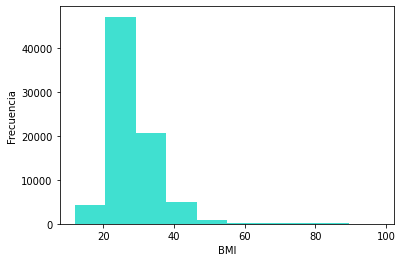

In [37]:
plt.figure()
datos_train['BMI'].hist(color='turquoise')
plt.grid(0)
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.show()

Asimismo, veamos el valor de la moda y la media:

In [38]:
print('La moda de BMI es: ', datos_train['BMI'].mode()[0])
print('La media de BMI es: ', datos_train['BMI'].mean())

La moda de BMI es:  27.0
La media de BMI es:  28.473267880761014


En este caso, es prácticamente indistinto el usar cualquiera de estas dos variables, así que tomemos la moda para que el procesamiento sea similar al de las otras variables del problema. Para ello, usamos el <code>SimpleImputer()</code> de sklearn. No obstante, esto lo haremos más adelante cuando construyamos las Pipelines en procesamiento.

Notemos que, en el caso de cuando vayamos a preprocesar el test, NO podemos imputar. Por ello, definimos una función en que los datos con NaN en el test son eliminados. En tal caso, solo eliminamos los datos.

In [39]:
def tratamiento_nulos(df, is_test=True):
    if is_test:
        df = df.dropna()
    return df

Podemos revisar, hasta el momento, cuántos datos hemos quitado y ver si vamos por buen camino:

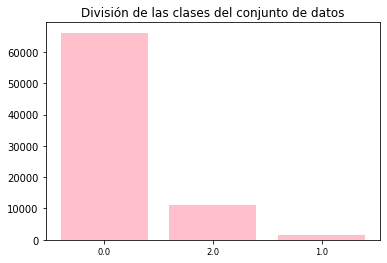

,Diabetes_012
0.0,66153
2.0,10994
1.0,1499


In [40]:
val_counts_y = datos_train['Diabetes_012'].value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='pink')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()
datos_train['Diabetes_012'].value_counts().to_frame()

Comparando con la primera gráfica que hicimos, vemos que, de la clase 2, apenas hemos eliminado 200 datos incompletos, lo cual está bien. De la clase 0 hemos quitado alrededor de 1000. No obstante, al ser una clase mayoritaria, no es un problema mayor. La clase 1 la trataremos más adelante, pero no nos es de particular interés por la naturaleza binaria de nuestro problema.

Finalmente, podemos evaluar ahora sí el mapa de correlación entre nuestras variables, una vez eliminada la basura. Esto podría ser de interés si queremos aplicar un algoritmo como regresión logística. 

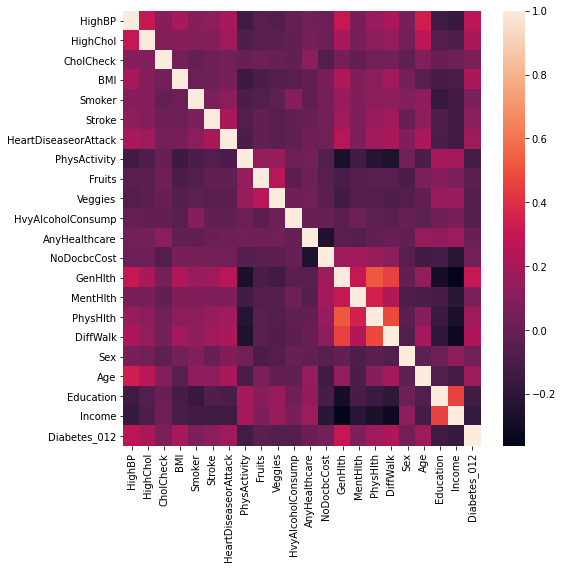

In [41]:
corr = datos_train.corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

Podemos ver que las correlaciones positivas (ni negativas) son lo suficientemente fuertes para considerar eliminar alguna variable. Hay algunas correlaciones (leves) entre variables como DiffWalk y PhysHealth, lo cual tiene sentido en el contexto del problema, pero no son realmente considerables.

Finalmente definimos una función para el preprocesamiento que hacemos para después aplicarlo sobre el test:

In [183]:
def preprocessing(df):
    df = eliminar_columnas_unnamed(df, col_inicial=22, col_final=26)
    eliminar_basura(df)
    df = eliminar_fuera_de_rango(df)
    df = eliminar_NaN_target(df)
    df = tratamiento_nulos(df)
    return df

Con esto, ya podemos proceder a la fase de procesamiento.

### 3. Procesamiento
Ahora procedemos a a realizar el procesamiento de los datos. Lo primero que decidimos es que, de acuerdo con el negocio, queremos saber si un paciente tiene diabetes **diagnosticada** o si no tiene diabetes. Es decir, tenemos un problema de clasificación binario. En este contexto, los datos que están clasificados con 1 (i.e. con prediabetes) son problemáticos. 

La prediabetes incluye rangos de insulina entre 100 y 125 mg/dL. No obstante, no tenemos forma de saber si los datos suministrados por los usuarios están más cerca de tener niveles de insulina normales (i.e. menores a 99 mg/dL) o diabéticos (mayores a 126 mg/dL) [1]. En este contexto, es difícil decidir si se deberían juntar los datos de prediabéticos con los de diabéticos (clase 2) o los no diabéticos (clase 1). Considerando además que, tras el preprocesamiento, únicamente hay 1499 datos de clase 1, es una decisión sensata eliminarlos. Por lo tanto, procedemos a eliminar estos datos.

In [43]:
datos_train = datos_train[datos_train['Diabetes_012'] != 1]

De esta forma, vemos que ahora solamente tenemos datos de dos clases: diabéticos (2) y normales (0).

In [44]:
datos_train['Diabetes_012'].value_counts().to_frame()

,Diabetes_012
0.0,66153
2.0,10994


Lo siguiente que debemos evaluar es decidir sobre los duplicados del conjunto de datos. Los datos duplicados son un problema puesto que pueden sesgar al algoritmo y al análisis. Más aún, en el momento de usar CrossValidation, pueden obtenerse scores sesgados para las métricas usadas. Lo anterior puesto que algunos de los datos duplicados pueden usarse tanto en el entrenamiento como en la validación, haciendo que el algoritmo esté sesgado y se obtengan mejores métricas que las que realmente deberían ser (pues el algoritmo ya vio los mismos datos).

Veamos entonces cuántos datos duplicados tenemos:

In [45]:
duplicados = datos_train[datos_train.duplicated()]
print("La cantidad de datos duplicados es: ", len(duplicados))
print('El porcentaje de datos duplicados es del {perc:.2f}%'.format(perc=len(duplicados)/len(datos_train)*100))

La cantidad de datos duplicados es:  4072
El porcentaje de datos duplicados es del 5.28%


Podemos ver que, en realidad, no son pocos datos duplicados, en realidad constituyen el 5.31% del total de datos que tenemos actualmente. Revisemos, por clase, cuántos duplicados hay.

In [46]:
duplicados['Diabetes_012'].value_counts().to_frame()

,Diabetes_012
0.0,4045
2.0,27


Vemos que la mayoría de duplicados hacen parte de la clase 0, lo cual da un poco de tranquilidad pues es la clase mayoritaria (i.e. de la que más datos tenemos). Así, no es preocupante eliminar estos datos. Procedemos, entonces, a eliminar los datos duplicados del conjunto train:

In [47]:
datos_train = datos_train.drop_duplicates()

Una vez eliminados los datos duplicados, revisemos la cantidad de datos nulos en el conjunto de datos:

In [48]:
datos_con_nan = datos_train[datos_train.isna().any(axis=1)]
print('La cantidad de filas con al menos un NaN es: ', len(datos_con_nan))
print('El porcentaje de datos duplicados es del {perc:.2f}%'.format(perc=len(datos_con_nan)/len(datos_train)*100))

La cantidad de filas con al menos un NaN es:  252
El porcentaje de datos duplicados es del 0.34%


Es un porcentaje bajo pero, como dijos en preprocesamiento, vamos a realizar imputación con la moda. Esto lo haremos en la pipeline más adelante.

Asimismo, veamos qué tan desbalanceado está nuestro conjunto de datos de train hasta el momento:

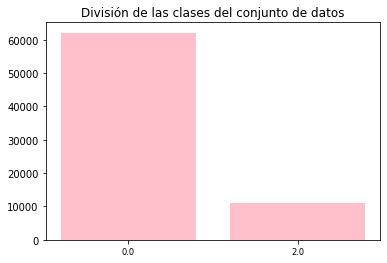

In [49]:
val_counts_y = datos_train['Diabetes_012'].value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='pink')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

Se hace evidente que necesitamos alguna técnica de balanceo de datos. En este caso, usaremos SMOTE (Synthetic Minority Over-sampling Technique) para balancear las clases. Elegimos hacer SMOTE en lugar de undersampling, pues, aunque tenemos un set de datos considerable, no queremos disminuir nuestro espacio de muestreo de una forma tan voraz. Así las cosas, aplicamos el algoritmo de SMOTE al conjunto de datos. Note que este proceso se hace después de realizar el manejo de valores con NaN en la pipeline.

Es importante mencionar que SMOTE recibe parámetros como la estrategia de remuestreo y la cantidad de vecinos que se usan para determinarlo. Aunque son parámetros interesantes, para este primer laboratorio nos satisfaremos con la versión por defecto que incluye la librería, 

Antes de construir las pipelines, es importante hablar sobre la forma en que le pasaremos los datos a nuestros modelos. Primero que todo, es importante mencionar que tenemos variables categóricas (como education, income y GenHealth), numéricas (como BMI, MenthHlth y PhysHlth) y binarias. Es importante notar que las variables categóricas tienen un carácter ordinal: es decir, tiene sentido organizarlas de menor a mayor (de menor income a mayor income, por ejemplo). Por esto, en un principio pensamos en mantener esta codificación ordinal para el algoritmo, y escalar los resultados entre 0 y 1 (Esto es necesario únicamente para el algoritmo que usa KNN).

No obstante, otra forma de codificar las variables es usando OneHotEncoding. Esto nos sirve para las categóricas. Decidimos probar ambos casos y pasarlo como hiperparámetro para ver cuál es la que escoge nuestro modelo.

Es importante notar que las variables numéricas deben ser escaladas en ambos casos (para KNN). Procedemos a seleccionar las columnas numéricas de las categóricas. A las numéricas, les haremos un escalamiento, en este caso dado por una normalización a 1. Esta es conveniente pues conserva la misma distribución de los datos pero los lleva a la misma escala, tal que no haya algunas variables que, espúremente, pesen más que otras al construir el modelo. Este escalamiento también lo hacemos a las categóricas después de haberlas codificado como ordinales.

In [64]:
# Volvemos a partir los datos en X_train y Y_train como lo habiamos hecho al inicio
Y_train = datos_train['Diabetes_012']
X_train = datos_train.drop(['Diabetes_012'], axis=1)

In [65]:
### Pipeline 1: usando el codificador ordinal
# Creamos el imputer, con la estrategia de la moda.
# Usamos un escalador MinMax para los algoritmos que los requieren (como KNN y LogReg).
# Aplicamos SMOTE, con los valores por defecto de la libreria.

pipe_ord = imbpipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                              ('scaler', MinMaxScaler()),
                              ('smote', SMOTE(random_state=28))])

Aplicamos la pipeline a los datos:

In [66]:
X_train_ord, Y_train_ord = pipe_ord.fit_resample(X_train, Y_train)

Revisemos primero que las clases hayan quedado efectivamente balanceadas:

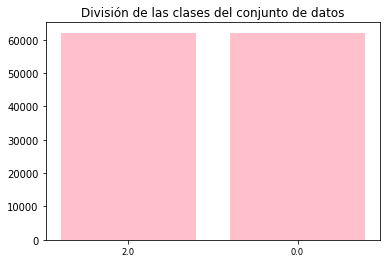

In [67]:
val_counts_y = Y_train_ord.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='pink')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

In [68]:
data_mod = pd.DataFrame(X_train_ord, columns=list(X_train.columns))

Vemos que el oversampling se hizo adecuadamente. Ahora ambas clases tienen la misma cantidad de datos. Asimismo, revisemos que no haya nulos:

In [69]:
print('La cantidad de nulos es: ', len(data_mod[data_mod.isna().any(axis=1)]))

La cantidad de nulos es:  0


Asimismo, revisamos que el escalamiento se haya dado eficientemente:

In [70]:
data_mod.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,...,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000,124216.000000
mean,0.575939,0.539795,0.975993,0.208992,0.482782,0.059545,0.144709,0.704906,0.609896,0.787887,...,0.954298,0.088018,0.460595,0.119604,0.189872,0.252416,0.452515,0.638072,0.788870,0.678219
std,0.493128,0.497572,0.151629,0.082648,0.498891,0.233260,0.350433,0.455200,0.487013,0.407601,...,0.205423,0.280432,0.267487,0.257229,0.325692,0.433538,0.496988,0.230962,0.194903,0.298444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.156157,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.500000,0.600000,0.428571
50%,1.000000,1.000000,1.000000,0.197674,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.666667,0.800000,0.714286
75%,1.000000,1.000000,1.000000,0.244186,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.663456,0.081914,0.184573,1.000000,1.000000,0.818943,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Es fácil intuir que las variables binarias permanecen como tal y, las numéricas o categóricas fueron escaladas adecuadamente (esto, revisando los percentiles para cada variable). Concluímos que se realizó adecuadamente.

Podríamos usar OneHot encoding, pero en este laboratorio optaremos solo por utilizar la codificación ordinal. Especialmente, porque las categorías tienen un sentido ordinal (i.e. son ordenadas) y porque tener más variables dummy, dadas por el OneHot, puede hacer que se ocupe mucha memoria y que el modelo tarde más en construirse.

## 4. Modelamiento

Como ya tenemos listas las dos pipelines, podemos proceder a construir nuestros modelos. Para cada modelo, hacemos un modelo básico con las dos pipelines construidas y, posteriormente, hacemos una búsqueda exhaustiva por hiperparámetros usando la funcionalidad GridSearch de CrossValidation de sklearn.

Es importante mencionar que, dado el contexto del modelo, lo que nos interesa es saber si un paciente tiene diabetes o no. En este caso, queremos minimizar la cantidad de pacientes con diabetes que son clasificados como no diabéticos. De esta forma, no nos importa tener algunos falsos positivos (i.e. no diabéticos que son clasificados como diabéticos), porque es más importante que todos los diabéticos sean clasificados así. Es así como la métrica que elegimos para evaluar nuestros modelos es el recall.

##  4.1 Modelo por KNN
K vecinos cercanos (K-NN) funciona bajo el principio de funcionamiento, el cual es el de representar un objeto en un plano dimensional de tamaño n en donde cada una de las dimensiones es un atributo de ese objeto, es decir, cada dimensión es cada una de las columnas del conjunto de datos. Con esto planteado, al final tendremos una serie de puntos ubicados en este plano. El objetivo de este algoritmo es ayudar a la predicción, por lo que, cuando queramos saber si un nuevo objeto o en este caso un nuevo punto clasifica en una categoría, tomaríamos en consideración los k puntos más cercanos (clasificados con base a la distancia euclidiana o la distancia de Manhattan) y la categoría con más puntos de este conjunto sería la categoría a asignar al nuevo punto.  

<img src="images/knn.png"/>

Lo primero que hacemos es construir un modelo de KNN básico. Es decir, podemos tomar los hiperparámetros definidos por defecto en la librería de <code>sklearn</code>. Estos son:
- n_neighbors = 5 vecinos. para el modelo base, usaremos 3 vecinos como hicimos en clase, para ahorrar tiempo de cómputo.
- weights = uniform (Todos los puntos en el vecindario son pesados igualmente).
- p = 2 (i.e. calcula las distancias usando la euclideana).

Después de eso, hacemos la búsqueda de hiperparámetros.

Probamos primero usando la pipe ordinal. Es decir, con los datos X_train_ord, Y_train_ord que habíamos sacado antes.

In [74]:
pipe_ord.steps.append(('classifier', KNeighborsClassifier(n_neighbors=3)))
pipe_ord

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=28)),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [75]:
pipe_ord.fit(X_train, Y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=28)),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [76]:
y_pred_ord_base = pipe_ord.predict(X_train)

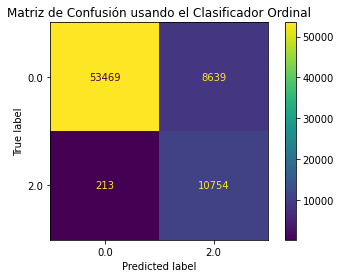

In [77]:
# Observamos la matriz de confusión correspondiente a nuestra predicción
plot_confusion_matrix(pipe_ord, X_train, Y_train, values_format='d')
plt.title('Matriz de Confusión usando el Clasificador Ordinal')
plt.show()

In [78]:
# Asimismo, vemos el reporte del algoritmo
print('----------Reporte para el Modelo KNN base ordinal----------')
print(classification_report(y_pred_ord_base, Y_train))

----------Reporte para el Modelo KNN base ordinal----------
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92     53682
         2.0       0.98      0.55      0.71     19393

    accuracy                           0.88     73075
   macro avg       0.92      0.78      0.82     73075
weighted avg       0.89      0.88      0.87     73075



Podemos ver, para este modelo preliminar, que el recall de la clase de interés (i.e. la clase 2) es un poco baja en entrenamiento: apenas del 0.55. No obstante, este es apenas nuestro modelo base y, en realidad, debemos aún construir el modelo basado en hiperparámetros. Vemos que el recall de la clase 0 es perfecto, lo cual es cuestionable también. De esta forma, procedemos a construir el modelo con **hiperparámetros**.

##### 4.1.2 Modelo usando Cross Validation

Ahora, procedemos a construir el modelo usando CrossValidation. En este caso, probamos varios parámetros para lo que diseñamos. Por ejemplo, intentamos escalar los datos usando MinMax o 'passthrough', para ver si en efecto el passthrough (i.e. no pesar las distancias) afecta a KNN. En realidad, no vale la pena probar muchos escaladores (Ver por ejemplo en la literatura el libro de Machine Learning de Geron, el escalamiento con varias técnicas como minmax o estandarización no produce diferencias significativas en el desempeño).

Asimismo, probamos un espacio de 3,5,7 vecinos para construir el algoritmo. Evitamos números muy grandes de vecinos que harán muy lento al algoritmo, y quizá overfittearlo, pero muy pequeños también que hagan que el modelo haga underfitting. Asimismo, intentamos ver qué sucede si consideramos distancias uniformes (i.e. las que vienen por defecto, o con el parámetro distance (i.e. pesando por 1/distancia). Asimismo, usamos varios valores para la métrica de Minkowski, siendo 1 la de Manhattan, 2 euclideana.

Debido a que la clase positiva en este caso es 2 (y no 1, como en un problema binario tradicional) debemos crear nuestra propia función de Score:

In [100]:
custom_scorer = make_scorer(recall_score, greater_is_better=True,  pos_label=2.0)

In [101]:
# Construimos los estimadores iniciales
estimators = [('imputer', SimpleImputer(strategy='most_frequent')),
                              ('scaler', MinMaxScaler()),
                              ('smote', SMOTE(random_state=28)),
                              ('classifier', KNeighborsClassifier() )]

# Creamos una pipe con eso
pipe_KNN = imbpipeline(steps=estimators)

# Creamos el diccionario de hiperparametros a probar
param_grid = dict(scaler=['passthrough', MinMaxScaler()],
                 classifier__n_neighbors = [3, 5, 7], 
                 classifier__weights = ['uniform', 'distance'],
                 classifier__p = [1,2])

# Por problemas con los tiempos de computo, consideramos solamente particiones de 2
# para realizar la validacion cruzada
grid_search_knn = GridSearchCV(estimator=pipe_KNN,
                           param_grid=param_grid,
                           scoring=custom_scorer,
                           cv=2, verbose=3)
grid_search_knn.fit(X_train, Y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 1/2] END classifier__n_neighbors=3, classifier__p=1, classifier__weights=uniform, scaler=passthrough;, score=0.387 total time=  55.7s
[CV 2/2] END classifier__n_neighbors=3, classifier__p=1, classifier__weights=uniform, scaler=passthrough;, score=0.390 total time=  55.2s
[CV 1/2] END classifier__n_neighbors=3, classifier__p=1, classifier__weights=uniform, scaler=MinMaxScaler();, score=0.464 total time=  58.4s
[CV 2/2] END classifier__n_neighbors=3, classifier__p=1, classifier__weights=uniform, scaler=MinMaxScaler();, score=0.455 total time=  53.2s
[CV 1/2] END classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance, scaler=passthrough;, score=0.383 total time=  56.5s
[CV 2/2] END classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance, scaler=passthrough;, score=0.386 total time=  56.7s
[CV 1/2] END classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance, scaler=MinMaxSca

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('scaler', MinMaxScaler()),
                                       ('smote', SMOTE(random_state=28)),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [3, 5, 7],
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance'],
                         'scaler': ['passthrough', MinMaxScaler()]},
             scoring=make_scorer(recall_score, pos_label=2.0), verbose=3)

In [102]:
print(grid_search_knn.best_params_)

{'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'uniform', 'scaler': 'passthrough'}


En este caso, podemos ver que, tras realizar la validación cruzada, el modelo de KNN preferido tiene:
- n_neighbors=7: 7 vecinos.
- p = 2: Usa la métrica Minkowski con p=2 (i.e. calcula las distancias usando la distancia euclideana).
- weights = uniform: Para pesar las distancias entre vecinos, usa una técnica uniforme. Esto quiere decir que todos los vecinos en el vecindario se pesan igual (i.e. los vecinos cercanos NO pesan más que los lejanos).
- passthrough: Prefiere NO escalar los datos.
El hecho de que el modelo prefiera NO escalar los datos nos llamó mucho la atención, porque en KNN son muy importantes las distancias entre vecinos, tal que el modelo es sensible ante datos lejanos. No obstante, notamos que esto se debía a que eligió que los pesos fuesen uniformes: con esto, el modelo compensa un poco el hecho de que haya algunos datos estén alejados. Esto, porque los vecinos se pesan igual, tal que los vecinos más cercanos no afectan más.

Más aún, en los resultados del GridSearchCV es posible notar que, en realidad, los resultados usando passthrough y MinMaxScaler son muy similares. La diferencia viene dada apenas en la tercera cifra decimal del recall obtenido. Con esto, nos damos cuenta que para este modelo en particular no era tan grave si los datos no estaban escalados.

Como esperábamos, el número de vecinos fue el más alto que consideramos en el espacio de búsqeuda: 7. Esto se debe a que, entre a más vecinos les pregunte el dato, mejores estimaciones puedo tener.

Finalmente, vemos que se eligió la métrica euclideana. Según la literatura (Gèron, 2019), esta es la mejor y más usada para este tipo de modelos, pero no esperamos en realidad que haya mucha diferencia con la métrica de Manhattan o usando métricas con parámetros superiores en espacios de Minkowski reales de mayor dimensionalidad

In [106]:
dump(grid_search_knn.best_estimator_, 'modelo_knn.joblib') 

knn_model = load('modelo_knn.joblib') 

pred1 = knn_model.predict(X_train)
print('----------Reporte para el Mejor Modelo KNN----------')
print(classification_report(Y_train, pred1))

----------Reporte para el Mejor Modelo KNN----------
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     62108
         2.0       0.37      0.98      0.54     10967

    accuracy                           0.75     73075
   macro avg       0.68      0.84      0.68     73075
weighted avg       0.90      0.75      0.78     73075



En la matriz anterior podemos ver los resultados del modelo que usa KNN. En este caso, entrenamos todos nuestros modelos para que eligiera el mejor estimador usando el recall (para la clase positiva).

Nos dimos cuenta de que el recall de la clase positiva es de 0.98: realmente es muy bueno y satisface nuestra necesidad de que el recall sea bastante alto para incluir a cuantos diabéticos sea posible, escapándose muy poco.

Asimismo, vemos que el recall macro promedio es de 0.84: este también es un buen valor si consideramos ambas clases en contraste. 

Exploremos ahora el algoritmo de los árboles de decisión.

## 4.2 Modelo por árboles de decisión
Árboles de decisión es una técnica de clasificación que consiste en la toma de decisiones en forma de árbol en donde cada nodo representa una decisión, de forma que cada camino nos acerca a la clasificación que se está buscando. 
 
El resultado final del proceso de construcción del modelo es un mapa de los resultados de las posibles decisiones. Este tiene un nodo superior (nodo raíz) el cual aprende a particionar en función del valor del atributo. Su estructura es similar a la de un diagrama de flujo, donde cada nodo interno representa determinada condición o regla de decisión que ayudará a clasificar el nuevo dato. 

<img src="images/arbol.png"/>


Lo primero que hacemos es construir un árbol de decisión básico. Es decir, podemos tomar los hiperparámetros definidos por defecto en la librería de <code>sklearn</code>. Estos son:

- Criterion: gini
- Splitter: best
- Max_depth: None
- Min_samples_split: 2


In [129]:
# Eliminamos el classifier anterior
pipe_ord.steps.pop()

('classifier', LogisticRegression(solver='saga'))

In [132]:
#Indicamos que el classifier que usaremos ahora es DecisionTreeClasifier
pipe_ord.steps.append(('classifier',DecisionTreeClassifier()))

In [133]:
#Construimos el modelo
arbol = pipe_ord.fit(X_train, Y_train)

#Determinamos las métricas de rendimiento (predicción) de este modelo
Y_pred_arbol_base = pipe_ord.predict(X_train)

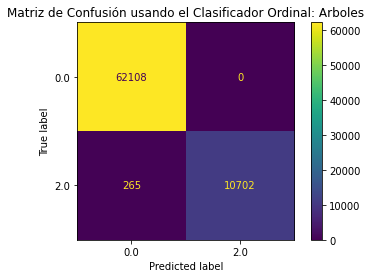

In [134]:
# Observamos la matriz de confusión correspondiente a nuestra predicción
plot_confusion_matrix(pipe_ord, X_train, Y_train, values_format='d')
plt.title('Matriz de Confusión usando el Clasificador Ordinal: Arboles')
plt.show()

In [135]:
# Asimismo, vemos el reporte del algoritmo
print('----------Reporte para el Modelo Arbol de Decision base ordinal----------')
print(classification_report(Y_pred_arbol_base, Y_train))

----------Reporte para el Modelo Arbol de Decision base ordinal----------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     62373
         2.0       0.98      1.00      0.99     10702

    accuracy                           1.00     73075
   macro avg       0.99      1.00      0.99     73075
weighted avg       1.00      1.00      1.00     73075



Vemos que las métricas son muy perfectas. Esto se debe a que no estamos limitando la profunidad del arbol.

In [136]:
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": arbol.steps[-1][1].feature_importances_})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,GenHlth,0.289838
1,BMI,0.221855
2,Age,0.144798
3,HighBP,0.074343
4,Income,0.048212
5,Education,0.036553
6,PhysHlth,0.035552
7,MentHlth,0.027933
8,HighChol,0.016213
9,Sex,0.013940


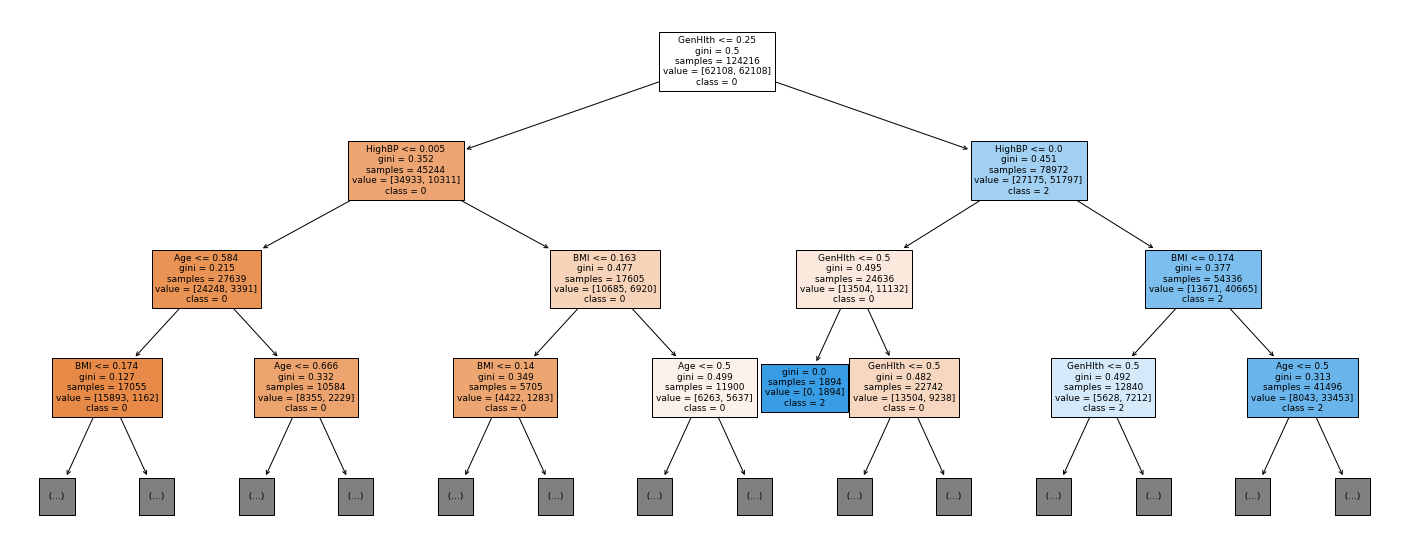

In [139]:
# Además, podemos visualizar el árbol.
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(arbol.steps[-1][1], max_depth=3, feature_names=X.columns, class_names=["0", "2"], filled=True, fontsize=9)

Observamos que seguramente el modelo generado está sobre ajustado, por lo que debemos cambiar el valor de los hiperparámetros, para lo cual haremos una exploración en un espacio de búsqueda para determinar la mejor configuración. De hecho, nos dimos cuenta que la profundidad del árbol era 53 en un código exploratorio que realizamos. La regularización es fundamental.


##### 4.2.2. Construcción del modelo con búsqueda de hiperparámetros.
En el caso de los árboles de decisión los hiperparámetros principales que hay que ajustar están relacionados con aquellos que controlan la complejidad, pero también el criterio o medida de pureza puede afectar su rendimiento. En general, estos son:  

* **criterion** : {“gini”, “entropy”}, predeterminado = "gini".

La función para medir la calidad de una división. Los criterios admitidos son "gini" y "entropía".

* **max_depth:** int, predeterminado=None.

La profundidad máxima del árbol. Si es None, los nodos se expanden hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos de min_samples_split muestras.

* **min_samples_split** : int or float, predeterminado=2.

El número mínimo de muestras necesarias para dividir un nodo interno.

In [143]:
# Construimos los estimadores iniciales
estimators = [('imputer', SimpleImputer(strategy='most_frequent')),
                              ('smote', SMOTE(random_state=28)),
                              ('classifier', DecisionTreeClassifier())]

# Creamos una pipe con estos estimadores
pipe_arboles = imbpipeline(steps=estimators)

# Creamos el diccionario de hiperparametros a probar
param_grid = dict(classifier__criterion = ["gini", "entropy"],
                  classifier__max_depth = [3,5,10,15,20],
                  classifier__min_samples_split = [2,3,4,5])

# Por problemas con los tiempos de computo, consideramos solamente particiones de 2
# para realizar la validacion cruzada
grid_search_arboles = GridSearchCV(estimator=pipe_arboles,
                           param_grid=param_grid,
                           scoring=custom_scorer,
                           cv=2, verbose=3)
grid_search_arboles.fit(X_train, Y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV 1/2] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=2;, score=0.545 total time=   0.9s
[CV 2/2] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=2;, score=0.604 total time=   1.0s
[CV 1/2] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=3;, score=0.545 total time=   1.0s
[CV 2/2] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=3;, score=0.604 total time=   0.9s
[CV 1/2] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=4;, score=0.545 total time=   0.9s
[CV 2/2] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=4;, score=0.604 total time=   1.0s
[CV 1/2] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=5;, score=0.545 total time=   0.9s
[CV 2/2] END classifie

[CV 1/2] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_split=5;, score=0.422 total time=   1.0s
[CV 2/2] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_split=5;, score=0.411 total time=   1.1s
[CV 1/2] END classifier__criterion=entropy, classifier__max_depth=15, classifier__min_samples_split=2;, score=0.327 total time=   1.1s
[CV 2/2] END classifier__criterion=entropy, classifier__max_depth=15, classifier__min_samples_split=2;, score=0.329 total time=   1.1s
[CV 1/2] END classifier__criterion=entropy, classifier__max_depth=15, classifier__min_samples_split=3;, score=0.328 total time=   1.0s
[CV 2/2] END classifier__criterion=entropy, classifier__max_depth=15, classifier__min_samples_split=3;, score=0.327 total time=   1.2s
[CV 1/2] END classifier__criterion=entropy, classifier__max_depth=15, classifier__min_samples_split=4;, score=0.328 total time=   1.1s
[CV 2/2] END classifier__criterion=entropy, classifier_

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('smote', SMOTE(random_state=28)),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [3, 5, 10, 15, 20],
                         'classifier__min_samples_split': [2, 3, 4, 5]},
             scoring=make_scorer(recall_score, pos_label=2.0), verbose=3)

In [144]:
#Como resultado de este proceso, observamos la mejor combinación de hiperparámetros para la construcción del modelo
print(grid_search_arboles.best_params_)

{'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_split': 2}


In [145]:
# Determinamos nuevamente las métricas de rendimiento y predicción de nuestro modelo
dump(grid_search_arboles.best_estimator_, 'modelo_arbol.joblib') 

best_arbol = load('modelo_arbol.joblib') 

pred1 = best_arbol.predict(X_train)
print('----------Reporte para el Mejor Modelo Arboles----------')
print(classification_report(Y_train, pred1))

----------Reporte para el Mejor Modelo Arboles----------
              precision    recall  f1-score   support

         0.0       0.92      0.78      0.84     62108
         2.0       0.33      0.60      0.42     10967

    accuracy                           0.75     73075
   macro avg       0.62      0.69      0.63     73075
weighted avg       0.83      0.75      0.78     73075



Después de generar el modelo con los anteriores hiperparámetros, podemos analizar la importancia de cada variable en nuestro conjunto de datos para la toma de decisiones y clasificación. Este valor es asignado según la medida de pureza que genere la decisión con base en este atributo. 

In [146]:
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": best_arbol.steps[-1][1].feature_importances_})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,HighBP,0.684955
1,GenHlth,0.247715
2,HighChol,0.067330
3,AnyHealthcare,0.000000
4,Education,0.000000
5,Age,0.000000
6,Sex,0.000000
7,DiffWalk,0.000000
8,PhysHlth,0.000000
9,MentHlth,0.000000


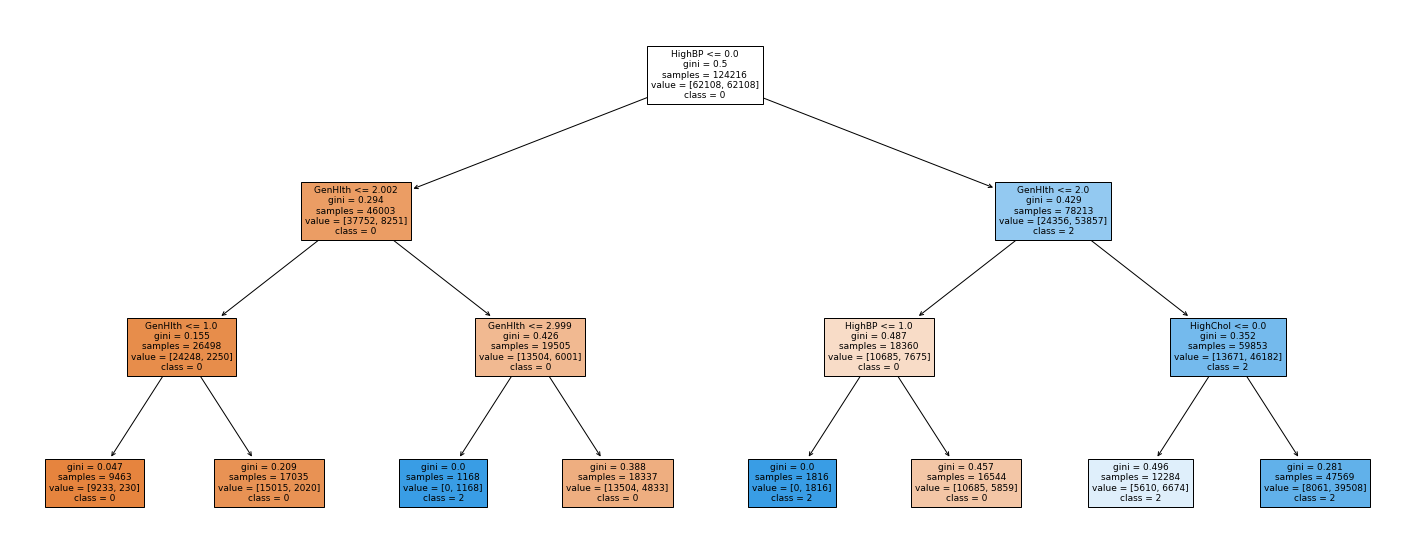

In [147]:
# Además, podemos visualizar el árbol.
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(best_arbol.steps[-1][1], max_depth=3, feature_names=X.columns, class_names=["0", "2"], filled=True, fontsize=9)

En el árbol es posible observar cómo el valor de importancia de cada atributo concuerda con su altura en las ramas del árbol. Es decir, entre más importancia tenga un atributo, más cerca estará de la raíz del árbol. Igualmente se puede observar cómo los atributos que tienen importancia 0 no se encuentran en el árbol y no son tomados en cuenta para tomar la decisión de clasificación de un dato. Esto se debe a que la profundidad es solamente 3, entonces solo hay 3 variables importantes en la construcción.

## 4.3 Modelo por regresión logística
La regresión logística se utiliza usualmente en contextos de clasificación binaria, como es el caso del problema que estamos tratando actualmente. Podemos usarlo porque es un modelo sencillo, sin mucha complejidad algorítmica, y porque además como vimos previamente en la matriz de correlación, tenemos un conjunto de datos en que las correlaciones entre las variables no son significativas.

Como nuestro problema a resolver es predecir si una persona tiene diabetes o no , podemos utilizar este método.  Este método usa la función logística o sigmoide, la cual está definida como: $$f(x) = \frac{1}{1 + e^{-x}}.$$

Si se grafica esta función, se puede ver que retorna 1 en caso de que el dominio tienda a infinito positivo y a cero cuando tiende a infinito negativo, lo cual la hace interesante para problemas de clasificación.




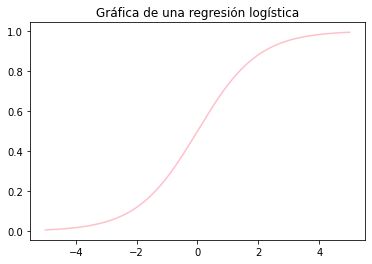

In [126]:
x = np.linspace(-5,5,1000)
y = (1 + np.exp(-x))**(-1)
plt.plot(x, y, c='pink')
plt.title('Gráfica de una regresión logística')
plt.show()

La regresión logística calcula una probabilidad, de acuerdo a la función sigmoide definida previamente. En el caso binario, si la probabilidad es mayor a 0.5 lo clasifica como la clase positiva (2=Diabetes, en este caso) y, si es menor, lo clasifica como de la clase negativa (0=No diabetes).

# TO DO: terminar explicación

Ahora, procedemos a construir el modelo por regresión logística. En este caso, usamos la librería saga porque, de acuerdo con la documentación de scikit learn, es la que mejor funciona para datasets grandes.

In [109]:
pipe_ord.steps.pop()
pipe_ord.steps.append(('classifier', LogisticRegression(solver='saga')))
pipe_ord

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=28)),
                ('classifier', LogisticRegression(solver='saga'))])

In [110]:
pipe_ord.fit(X_train, Y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=28)),
                ('classifier', LogisticRegression(solver='saga'))])

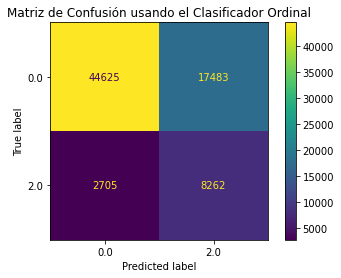

----------Reporte para el Modelo de Regresion Logistica base ordinal----------
              precision    recall  f1-score   support

         0.0       0.72      0.94      0.82     47330
         2.0       0.75      0.32      0.45     25745

    accuracy                           0.72     73075
   macro avg       0.74      0.63      0.63     73075
weighted avg       0.73      0.72      0.69     73075



In [111]:
y_pred_ord_base = pipe_ord.predict(X_train)

# Observamos la matriz de confusión correspondiente a nuestra predicción
plot_confusion_matrix(pipe_ord, X_train, Y_train, values_format='d')
plt.title('Matriz de Confusión usando el Clasificador Ordinal')
plt.show()

# Asimismo, vemos el reporte del algoritmo
print('----------Reporte para el Modelo de Regresion Logistica base ordinal----------')
print(classification_report(y_pred_ord_base, Y_train))

# TO DO: Explicar. 

##### 4.2.2. Construcción del modelo con búsqueda de hiperparámetros.
En el caso de la regresión logística, los hiperparámetros principales que hay que ajustar están relacionados con aquellos que controlan la complejidad. En general, estos son:  

# TO DO

Con un modelo básico funcionando, procedemos a hacer un GridSearch junto con validación cruzada (n=3), de manera que una búsqueda más exhaustiva sobre los hiperparámetros nos provea un mejor modelo, y con la validación cruzada, resultados estadísticamente más significativos. Así las cosas, para la normalización elegimos dos opciones: no normalizar (passthrough), y escalar con el rango (MinMaxScaler). Para C (el parámetro inverso de la regularización), se hizo un barrido de diez valores en el espacio logarítmico entre $10^{-3}$ y $10^3$ . Entre mayor sea el valor de C, menor alta es la regularización del modelo. Asimismo, usamos dos tipos de penalización: L1 y L2. De estos dos tipos de penalización, que corresponden a Lasso y Ridge respectivamente, queremos ver cuál es más óptimo para nuestro modelo. Note que el solver <code>saga</code> soporta ambos tipos de penalización.

In [121]:
# Construimos los estimadores iniciales
estimators = [('imputer', SimpleImputer(strategy='most_frequent')),
                              ('scaler', MinMaxScaler()),
                              ('smote', SMOTE(random_state=28)),
                              ('classifier', LogisticRegression(solver='saga', max_iter=1000) )]

# Creamos una pipe con eso
pipe_log_regression = imbpipeline(steps=estimators)

# Creamos el diccionario de hiperparametros a probar
param_grid = dict(scaler=['passthrough', MinMaxScaler()],
                 classifier__C = np.logspace(-3,3,10),
                 classifier__class_weight = ['balanced', None],
                 classifier__penalty = ['l1', 'l2'])

# Por problemas con los tiempos de computo, consideramos solamente particiones de 2
# para realizar la validacion cruzada
grid_search_lr = GridSearchCV(estimator=pipe_log_regression,
                           param_grid=param_grid,
                           scoring=custom_scorer,
                           cv=2, verbose=3)
grid_search_lr.fit(X_train, Y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits
[CV 1/2] END classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l1, scaler=passthrough;, score=0.749 total time=   3.9s
[CV 2/2] END classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l1, scaler=passthrough;, score=0.749 total time=   4.3s
[CV 1/2] END classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l1, scaler=MinMaxScaler();, score=0.737 total time=   1.2s
[CV 2/2] END classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l1, scaler=MinMaxScaler();, score=0.747 total time=   1.1s
[CV 1/2] END classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l2, scaler=passthrough;, score=0.749 total time=   7.2s
[CV 2/2] END classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l2, scaler=passthrough;, score=0.748 total time=   7.5s
[CV 1/2] END classifier__C=0.001, classifier__class_weight=bal

[CV 2/2] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, scaler=passthrough;, score=0.753 total time=  14.3s
[CV 1/2] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, scaler=MinMaxScaler();, score=0.751 total time=   1.0s
[CV 2/2] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, scaler=MinMaxScaler();, score=0.749 total time=   1.0s
[CV 1/2] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, scaler=passthrough;, score=0.750 total time=  14.3s
[CV 2/2] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, scaler=passthrough;, score=0.753 total time=  16.3s
[CV 1/2] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, scaler=MinMaxScaler();, score=0.752 total time=   1.2s
[CV 2/2] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, scaler=MinMaxScaler();, score=0.749 total time=   1.3s
[CV

[CV 1/2] END classifier__C=10.0, classifier__class_weight=None, classifier__penalty=l2, scaler=passthrough;, score=0.750 total time=  13.8s
[CV 2/2] END classifier__C=10.0, classifier__class_weight=None, classifier__penalty=l2, scaler=passthrough;, score=0.753 total time=  16.7s
[CV 1/2] END classifier__C=10.0, classifier__class_weight=None, classifier__penalty=l2, scaler=MinMaxScaler();, score=0.752 total time=   1.1s
[CV 2/2] END classifier__C=10.0, classifier__class_weight=None, classifier__penalty=l2, scaler=MinMaxScaler();, score=0.749 total time=   1.1s
[CV 1/2] END classifier__C=46.41588833612773, classifier__class_weight=balanced, classifier__penalty=l1, scaler=passthrough;, score=0.750 total time=  15.7s
[CV 2/2] END classifier__C=46.41588833612773, classifier__class_weight=balanced, classifier__penalty=l1, scaler=passthrough;, score=0.753 total time=  16.4s
[CV 1/2] END classifier__C=46.41588833612773, classifier__class_weight=balanced, classifier__penalty=l1, scaler=MinMaxSc

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('scaler', MinMaxScaler()),
                                       ('smote', SMOTE(random_state=28)),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           solver='saga'))]),
             param_grid={'classifier__C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'classifier__class_weight': ['balanced', None],
                         'classifier__penalty': ['l1', 'l2'],
                         'scaler': ['passthrough', MinMaxScaler()]},
             scoring=make_scorer(recall_score, pos_label=2.0), verbose=3

In [127]:
print(grid_search_lr.best_params_)

{'classifier__C': 0.021544346900318832, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'scaler': MinMaxScaler()}


De acuerdo con los hiperparámetros descritos previamente, en este caso tenemos que nuestra validación cruzada escogió los siguientes parámetros:
- C = 0.02: Como dijimos previamente, un valor de C más cercano a 0 indica que el modelo está más regularizado.
- class_weight = None: El modelo prefirió no balancear los datos dependiendo de las frecuencias. Esto se debe seguramente al hecho de que se utilizó SMOTE.
- Penalización $L1$: Conviene utilizar una regresión Lasso, de acuerdo a lo explicado previamente.
- Escalador MinMax(): Para este modelo, a diferencia de KNN, sí se prefirió tener los datos escalados, lo cual tiene sentido de acuerdo con lo que se espera de regresión logística.

Veamos el reporte de clasificación:

In [128]:
dump(grid_search_lr.best_estimator_, 'modelo_lr.joblib') 

lr_model = load('modelo_lr.joblib') 

predlr = lr_model.predict(X_train)
print('----------Reporte para el Mejor Modelo Regresion Logistica----------')
print(classification_report(Y_train, predlr))

----------Reporte para el Mejor Modelo Regresion Logistica----------
              precision    recall  f1-score   support

         0.0       0.94      0.72      0.82     62108
         2.0       0.32      0.75      0.45     10967

    accuracy                           0.72     73075
   macro avg       0.63      0.74      0.63     73075
weighted avg       0.85      0.72      0.76     73075



A diferencia del caso con KNN, vemos que el mejor modelo nos da un recall del 75% para la clase positiva, y del 72% para la clase negativa. La diferencia con KNN es que la métrica está mucho más balanceada para regresión logística que para KNN (entre las dos clases). No obstante, 75% de recall es un muy buen valor. Sobre todo comparado con el de árboles, cuyo recall fue apenas de 0.60. Esto se debe a que los árboles son, en realidad, modelos muy sencillos. Para que funcionen bien, es necesario utilizar modelos de ensamble como RandomForest que, en su versión básica, usa 100 árboles para tomar una decisión.

Ahora, procedemos a hacer la validación de los datos usando el conjunto de test.

## 5. Validación y Test
Probamos el conjunto de test que separamos al inicio con cada uno de los tres modelos. Para ello, pasamos los datos por el preprocesamiento definido:

In [185]:
datos_test = X_test.assign(Diabetes_012 = Y_test)

In [186]:
datos_test = preprocessing(datos_test)

In [188]:
Y_test = datos_test['Diabetes_012']
X_test = datos_test.drop(['Diabetes_012'], axis=1)

Para KNN:

In [189]:
y_pred_knn = knn_model.predict(X_test)
print('----------Reporte para el Mejor Modelo con datos nuevos KNN ----------')
print(classification_report(Y_test, y_pred_knn))

----------Reporte para el Mejor Modelo con datos nuevos KNN ----------
              precision    recall  f1-score   support

         0.0       0.92      0.67      0.78     16518
         1.0       0.00      0.00      0.00       363
         2.0       0.25      0.69      0.37      2729

    accuracy                           0.66     19610
   macro avg       0.39      0.45      0.38     19610
weighted avg       0.81      0.66      0.70     19610



Para árboles de decisión:

In [190]:
y_pred_arbol = best_arbol.predict(X_test)
print('----------Reporte para el Mejor Modelo con datos nuevos arboles ----------')
print(classification_report(Y_test, y_pred_arbol))

----------Reporte para el Mejor Modelo con datos nuevos arboles ----------
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85     16518
         1.0       0.00      0.00      0.00       363
         2.0       0.32      0.61      0.42      2729

    accuracy                           0.76     19610
   macro avg       0.41      0.47      0.42     19610
weighted avg       0.81      0.76      0.78     19610



Para regresión logística:

In [191]:
y_pred_lr = lr_model.predict(X_test)
print('----------Reporte para el Mejor Modelo con datos nuevos regresion ----------')
print(classification_report(Y_test, y_pred_lr))

----------Reporte para el Mejor Modelo con datos nuevos regresion ----------
              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83     16518
         1.0       0.00      0.00      0.00       363
         2.0       0.31      0.76      0.45      2729

    accuracy                           0.73     19610
   macro avg       0.42      0.50      0.42     19610
weighted avg       0.84      0.73      0.76     19610



### Bibliografía 
[1] https://as.com/deporteyvida/2019/11/13/portada/1573663111_178652.html